# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,106
Number of N/A: 19


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9106, minmax=(17, 5585), mean=432.19646386997584, variance=124206.00763603917, skewness=2.217817524586907, kurtosis=10.294480522289216)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Source/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

Born Yesterday (1950)

Uncouth, loud-mouth junkyard tycoon Harry Brock descends upon Washington D.C. to buy himself a congressman or two, bringing with him his mistress, ex-showgirl Billie Dawn. Brock hires newspaperman Paul Verrall to see if he can soften her rough edges and make her more presentable in capital society. But Harry gets more than he bargained for as Billie absorbs Verall's lessons in U.S. history and not only comes to the realization that Harry is nothing but a two-bit, corrupt crook, but in the process also falls in love with her handsome tutor.

['uncouth', ',', 'loud-mouth', 'junkyard', 'tycoon', 'harry', 'brock', 'descends', 'upon', 'washington', 'd.c.', 'to', 'buy', 'himself', 'a', 'congressman', 'or', 'two', ',', 'bringing', 'with', 'him', 'his', 'mistress', ',', 'ex-showgirl', 'billie', 'dawn', '.', 'brock', 'hires', 'newspaperman', 'paul', 'verrall', 'to', 'see', 'if', 'he', 'can', 'soften', 'her', 'rough', 'edges', 'and', 'make', 'her', 'more', 'presentable', '

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

38387

Documents size:

9106

Most common words (+UNK):

[(',', 39543), ('the', 37983), ('.', 29809), ('a', 24721), ('to', 22220)]

Document example: id=3341

Born Yesterday (1950) 

Uncouth, loud-mouth junkyard tycoon Harry Brock descends upon Washington D.C. to buy himself a congressman or two, bringing with him his mistress, ex-showgirl Billie Dawn. Brock hires newspaperman Paul Verrall to see if he can soften her rough edges and make her more presentable in capital society. But Harry gets more than he bargained for as Billie absorbs Verall's lessons in U.S. history and not only comes to the realization that Harry is nothing but a two-bit, corrupt crook, but in the process also falls in love with her handsome tutor. 

[24761, 1, 23195, 7860, 3190, 478, 11304, 3793, 333, 1062, 2448, 5, 1132, 99, 4, 5989, 106, 52, 1, 2001, 13, 29, 10, 1589, 1, 18748, 4589, 2213, 3, 11304, 950, 13870, 422, 21257, 5, 221, 131, 11, 61, 12490, 14, 4362, 12170, 6, 122, 14, 80, 31353, 8, 2

In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (1, ,) -> (23195, loud-mouth)
0: (1, ,) -> (24761, uncouth)
0: (23195, loud-mouth) -> (7860, junkyard)
0: (23195, loud-mouth) -> (1, ,)
0: (7860, junkyard) -> (23195, loud-mouth)
0: (7860, junkyard) -> (3190, tycoon)
0: (3190, tycoon) -> (7860, junkyard)
0: (3190, tycoon) -> (478, harry)
0: (478, harry) -> (3190, tycoon)
0: (478, harry) -> (11304, brock)

2nd Batch:

0: (11304, brock) -> (3793, descends)
0: (11304, brock) -> (478, harry)
0: (3793, descends) -> (11304, brock)
0: (3793, descends) -> (333, upon)
0: (333, upon) -> (3793, descends)
0: (333, upon) -> (1062, washington)
0: (1062, washington) -> (333, upon)
0: (1062, washington) -> (2448, d.c.)
0: (2448, d.c.) -> (1062, washington)
0: (2448, d.c.) -> (5, to)

3rd Batch:

0: (5, to) -> (2448, d.c.)
0: (5, to) -> (1132, buy)
0: (1132, buy) -> (99, himself)
0: (1132, buy) -> (5, to)
0: (99, himself) -> (1132, buy)
0: (99, himself) -> (4, a)
0: (4, a) -> (5989, congressman)
0: (4, a) -> (99, himself)
0: (5989, congr

In [8]:
import tensorflow as tf

class Doc2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width))
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width))
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, model, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(model.words_embeddings, input_words)
        similarity = tf.matmul(words_embeddings, model.words_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, model, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(model.docs_embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, model.docs_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Doc2vecTrainer:
    
    #dataset
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
    
    def train(self, num_epochs=1, delay_lr_decay=0):
        data_reader = self.data_reader()
        
        with tf.Graph().as_default(), tf.Session() as session:
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            init = tf.global_variables_initializer()
            session.run(init)
            print('Initialized.\n')
            
            train_ops = [model.train, model.loss]
            average_loss = 0
            
            step = 0
            last_epoch = data_reader.num_epoch
            while data_reader.num_epoch < num_epochs:
                batch_docs, batch_data, batch_labels = data_reader.read()
                feed_dict = {
                    model.input_docs: batch_docs,
                    model.input_data: batch_data,
                    model.input_labels: batch_labels,
                }
                
                _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                average_loss += loss_val

                if step % 5000 == 0:
                    if step > 0:
                        average_loss /= 5000
                    print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                    average_loss = 0
                                
                step += 1
                
                if data_reader.num_epoch != last_epoch:
                    last_epoch = data_reader.num_epoch

                    lr = model.lr(session)
                    if last_epoch >= delay_lr_decay:
                        model.assign_lr(session, max(0.00001, lr / 2))
                    
                    print()
                    print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                    print()
                    doc_query.run(session)
                    word_query.run(session)
                    print()

            print('Total steps: {:,d}'.format(step))
            
            docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Doc2vecModel(self.corpus.documents_size,
                            self.corpus.vocabulary_size,
                            self.embedding_size,
                            self.num_sampled,
                            self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)


In [9]:
%%time

doc_trainer = Doc2vecTrainer(
    train_corpus,
    batch_size = 16,
    skip_window = 2,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 100,     # Number of negative examples to sample.
    learning_rate = 0.2)   # Initial learning rate.

docs_embeddings = doc_trainer.train(num_epochs=25, delay_lr_decay=8)

Initialized.

Average loss at step 0: 398.288
Average loss at step 5,000: 78.449
Average loss at step 10,000: 25.842
Average loss at step 15,000: 19.864
Average loss at step 20,000: 17.761
Average loss at step 25,000: 15.687
Average loss at step 30,000: 14.035
Average loss at step 35,000: 13.261
Average loss at step 40,000: 12.846
Average loss at step 45,000: 12.340
Average loss at step 50,000: 11.454
Average loss at step 55,000: 11.157
Average loss at step 60,000: 10.935
Average loss at step 65,000: 10.814
Average loss at step 70,000: 10.186
Average loss at step 75,000: 9.743
Average loss at step 80,000: 9.923
Average loss at step 85,000: 9.618
Average loss at step 90,000: 9.561

Epoch 1 (lr=0.20000)

Chuck Berry Hail! Hail! Rock 'n' Roll (1987)

This documentary covers the concert at the Fox Theatre in St. Louis, Missouri, to celebrate Chuck Berry's sixtieth birthday, and also discusses his life and career.

[ 1, 0.998 ] Shame (2011)

Brandon is a 30-something man living in New York 

In [18]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 1min 57s, sys: 13 s, total: 2min 10s
Wall time: 2min 2s


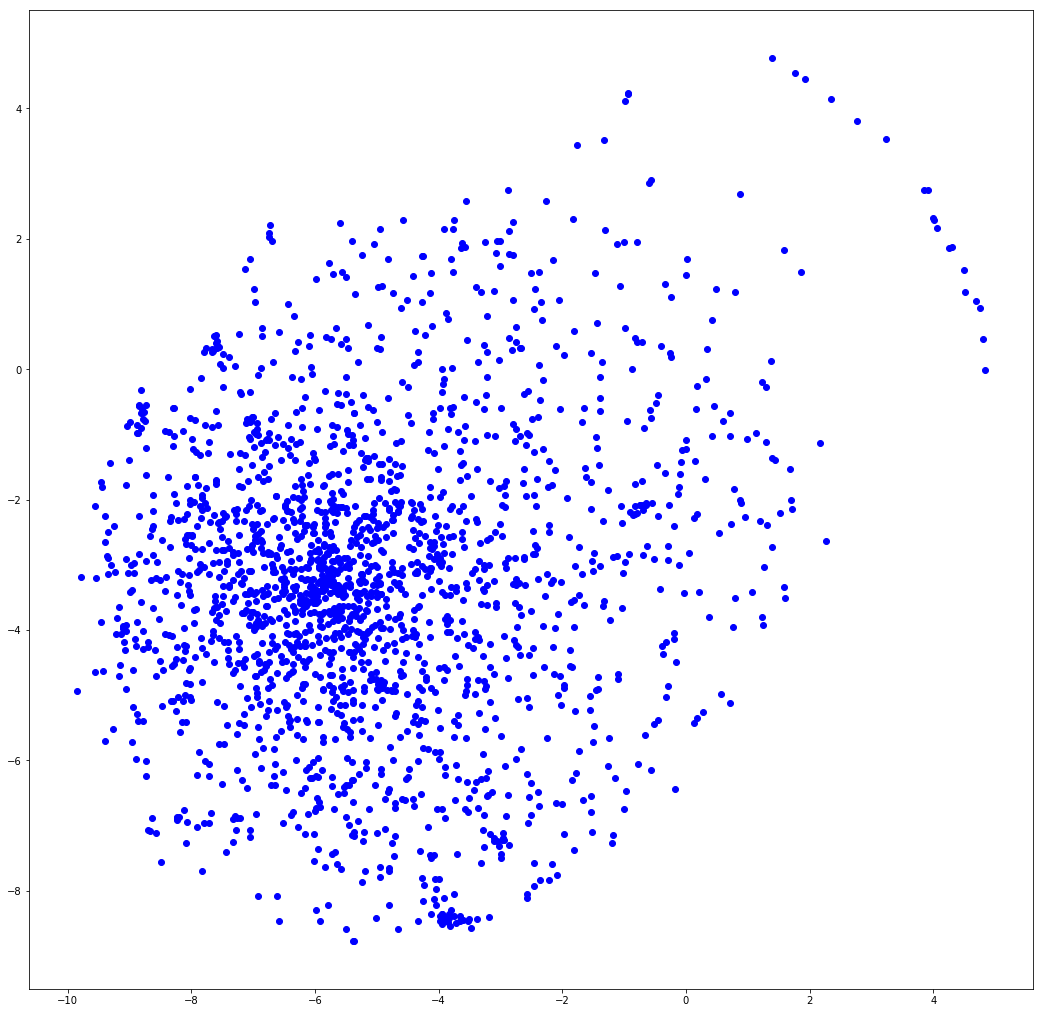

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()